In [2]:
import pandas as pd
import numpy as np



import autograd.numpy as anp


from pymoo.model.evaluator import Evaluator
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.algorithms.rnsga3 import RNSGA3
from pymoo.algorithms.so_gradient_descent import GradientDescent
from pymoo.model.repair import Repair
from pymoo.factory import *


from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, brier_score_loss, log_loss

# TODO:
- Find an example for multi-class classification (not multi-label)
- Decide if we support REJECTS in the ground truth

In [3]:
df = pd.read_csv("../input/mailguard-labeled-results.csv")

inputs = {
    "id_column": "mid",
    "ground_truth_column": "ground_truth",
    "reject_label": "REJECT",
    "min": 0,
    "max": 1,
    
    "probability_column" : "probabilities",  # Optional???
    "target_label" : "spam",                 # Optional???
    
}

In [8]:
df = pd.read_csv("../input/predictions-email-classifier-percept_20191014-161825.csv")
inputs = {
    "id_column": "email_id",
    "ground_truth_column": "work_type",
    "reject_label": "REJECT",
    "min": 0,
    "max": 100
}

In [9]:
def ids_are_unique(df, inputs):
    return len(df[inputs["id_column"]].unique()) == len(df[inputs["id_column"]])

def retrieve_labels(df, inputs):
    return df[inputs["ground_truth_column"]].str.strip().sort_values().unique()

def rejects_are_present(df, inputs):
    return df[inputs["ground_truth_column"]].str.strip().str.contains(inputs["reject_label"]).any()

def check_labels_have_columns(df, labels):
    return len(set(df.columns) & set(labels)) == len(labels)

def normalise_probs_in_place(df, inputs, labels):
    if inputs["min"] == 0 and inputs["max"] == 100:
        for label in labels:
            if label == inputs["reject_label"]:
                continue
            if (df[label] < 1).any() and (df[label] >= 0).any():
                return 
            df[label] = df[label] / 100      
    elif inputs["min"] == 0 and inputs["max"] == 1:
        # TODO: Check that the provided constraints are not violated 
        return
    else:
        raise ValueError("Normalisation rule not specified")
    
def prepare_labels(df, inputs):
    labels = retrieve_labels(df, inputs)

    if "target_label" in inputs:
        labels = list(filter(lambda x: x == inputs["target_label"], labels))
    
    if not check_labels_have_columns(df, labels) and not "probability_column" in inputs:
        raise ValueError("Labels do not have column names for probabilities")   
        
    return sorted(labels)


def prepare_ground_truth(df, inputs, mapping):
    ids = []
    truth_columns = inputs["ground_truth_column"]

    if not "target_label" in inputs:
        all_labels = []
        for a_id in df[inputs["id_column"]].unique():
            ground_truth_labels = df[df[inputs["id_column"]] == a_id][truth_columns]
            indexes = [mapping[s.strip()] for s in list(ground_truth_labels)]     
            ground_truth = np.zeros(len(mapping), dtype=int)
            ground_truth[indexes] = 1
            ids.append(a_id)
            all_labels.append(ground_truth)
        columns = list(mapping.keys())
        ground_truth = pd.DataFrame(all_labels)
        ground_truth.columns = columns
    else:
        ids = df[inputs["id_column"]].unique()
        ground_truth = pd.DataFrame()
        ground_truth[inputs["target_label"]] = (df[truth_columns] == inputs["target_label"]) * 1
      
    ground_truth["id"] = ids    
    return ground_truth

def derive_probabilities(df, inputs):
    if "probability_column" in inputs:
        probabilities = pd.DataFrame()
        probabilities[inputs["target_label"]] = df[inputs["probability_column"]]
        probabilities["id"] = df[inputs["id_column"]]
    else:
        labels = list(retrieve_labels(df, inputs))
        labels.insert(0, inputs["id_column"])
        probabilities = df[labels]
        probabilities = probabilities.rename(columns={inputs["id_column"]: "id"})
    return probabilities.drop_duplicates("id")

def thres(x, lower, upper):
    not_match = np.less(x, lower)
    match = np.greater_equal(x, upper)
    rejects = ~np.logical_xor(not_match, match)
    return np.stack([not_match, match, rejects])

def matches(x):
    return np.where(x == True)
    
def calculate_thresholds(labels, probabilities, thresholds):
    predictions = pd.DataFrame()
    for l in labels:
        probs = probabilities[l]
        lower = thresholds[l]["lower"]
        upper = thresholds[l]["upper"]
        if lower > upper:
            raise ValueError("Lower %f should be less than %f" %(lower, upper))
        results = matches(thres(probs, lower, upper))
        sorted_index = np.argsort(results)[1]
        predictions[l] = results[0][sorted_index]
    predictions["id"] = df[inputs["id_column"]]
    return predictions

def calculate_all_confusion_matricies(ground_truth, thresholded, labels):
    all_matrices = []
    for l in labels:
        matrix = confusion_matrix(ground_truth[l], thresholded[l])
        if np.shape(matrix) < (3,3):
            matrix = np.c_[matrix, np.zeros(2)]
            matrix = np.r_[matrix, [np.zeros(3)]]   
        all_matrices.append(matrix)
    results = np.array(all_matrices, dtype=np.int)
    
    # Column order: matches, not match, rejects
    results[:,:,[0,1]] = results[:,:,[1, 0]]
    
    # Row order: matches, not match, rejects
    results[:,[0,1], :] = results[:,[1, 0], :]
    return results

In [10]:
labels = prepare_labels(df, inputs)
mapping = {label: i for i, label in enumerate(labels)}
normalise_probs_in_place(df, inputs, labels)

ground_truth = prepare_ground_truth(df, inputs, mapping)
probabilities = derive_probabilities(df, inputs) 

In [11]:
thresholds = {}
for l in labels:
    thresholds[l] = {"lower": 0.60, "upper": 0.70}

thresholded = calculate_thresholds(labels, probabilities, thresholds)

len(thresholded), len(probabilities), len(ground_truth)

(5366, 5366, 5366)

In [13]:
all_matrices = calculate_all_confusion_matricies(ground_truth, thresholded, labels)
all_matrices
#thresholded[labels[0]][thresholded[labels[0]] == 0][ground_truth[labels[0]] == 0]

array([[[120, 109, 33],
        [28, 5017, 59],
        [0, 0, 0]],

       [[0.0, 3.0, 0.0],
        [0.0, 5363.0, 0.0],
        [0.0, 0.0, 0.0]],

       [[78, 46, 9],
        [10, 5211, 12],
        [0, 0, 0]],

       [[53, 211, 45],
        [55, 4897, 105],
        [0, 0, 0]],

       [[502, 239, 105],
        [158, 4234, 128],
        [0, 0, 0]],

       [[230, 68, 19],
        [21, 5003, 25],
        [0, 0, 0]],

       [[258, 68, 35],
        [43, 4920, 42],
        [0, 0, 0]],

       [[0, 14, 1],
        [0, 5351, 0],
        [0, 0, 0]],

       [[2119, 278, 120],
        [190, 2524, 135],
        [0, 0, 0]],

       [[606, 158, 75],
        [55, 4419, 53],
        [0, 0, 0]]], dtype=object)

In [14]:
threshold_matches = thresholded[thresholded[labels] == 1][labels].count()
ground_truth_matches = ground_truth[ground_truth[labels] == 1][labels].count()

results = pd.DataFrame()
results["label_bias"] = 1- threshold_matches / ground_truth_matches
results["reject_count"] = all_matrices[:,:,2].sum(axis=1, dtype=np.int)
results["ground_truth_counts"] = ground_truth_matches
results["prediction_counts"] = threshold_matches
results

,label_bias,reject_count,ground_truth_counts,prediction_counts
add_funds,0.435115,92,262,148
advice,1.000000,0,3,0
claim,0.338346,21,133,88
i_dont_understand_whats_happening,0.650485,150,309,108
info,0.219858,233,846,660
invest,0.208202,44,317,251
setup,0.166205,77,361,301
transfer,1.000000,1,15,0
update,0.082638,255,2517,2309
withdraw,0.212157,128,839,661


In [15]:
summary_results = {
    "true_matches" : all_matrices[:,0][:,0].sum(),
    "false_matches": all_matrices[:,1][:,0].sum(),
    "missed_matches": all_matrices[:,0][:,1].sum(),
    "rejects": all_matrices[:,:,2].sum(),
    "totals": len(ground_truth)
}

summary_results

{'true_matches': 3966.0,
 'false_matches': 560.0,
 'missed_matches': 1194.0,
 'rejects': 1001.0,
 'totals': 5366}

# Optimisation of the thresholds

In [16]:
cost = {
    "true_matches": 1000,
    "false_matches": 3000,
    "missed_matches": 500,
    "rejects": 500,
    "portion_size" : 1000,
    "estimate_quantity":10000
}


labels = prepare_labels(df, inputs)

mapping = {label: i for i, label in enumerate(labels)}
normalise_probs_in_place(df, inputs, labels)

ground_truth = prepare_ground_truth(df, inputs, mapping)
probabilities = derive_probabilities(df, inputs) 


ground_truth_matches = ground_truth[ground_truth[labels] == 1][labels].count()


In [17]:
def calculate_matches(x, lower, upper):
    not_match = np.less(x, lower)
    match = np.greater_equal(x, upper)
    rejects = ~np.logical_xor(not_match, match)
    return np.stack([not_match, match, rejects])

def apply_thresholds(probabilities, lower, upper):
    temp = calculate_matches(probabilities, lower, upper)
    def value(x):
        return np.where(x == True)[0][0]
    return np.apply_along_axis(value, 0, temp)
 
def calculate_confusion_matrices(gt, pred):
    result = np.zeros((gt.shape[1],3,3), dtype=np.int)
    for i,(x,y) in enumerate(zip(gt.T,pred.T)):
        matrix = confusion_matrix(x,y)
        if np.shape(matrix) < (3,3):
            matrix = np.c_[matrix, np.zeros(2)]
            matrix = np.r_[matrix, [np.zeros(3)]]
        elif np.shape(matrix) > (3, 3):
            raise ValueError("Matrix should be 3x3, error in input labels")

        # Column order: matches, not match, rejects
        matrix[:,[0,1]] = matrix[:,[1, 0]]
        # Row order: matches, not match, rejects 
        matrix[[0,1], :] = matrix[[1, 0], :]

        result[i] = matrix
    return result


def get_objective(probabilities, ground_truth, lower_thresholds, upper_thresholds):
    thres = apply_thresholds(probabilities, lower_thresholds, upper_thresholds)  
    all_results = calculate_confusion_matrices(ground_truth, thres)
    return np.array([all_results[:,0][:,0].sum(),
            all_results[:,1][:,0].sum(),
            all_results[:,0][:,1].sum(),
            all_results[:,:,2].sum()])



np_probs = probabilities[labels].to_numpy()    
gt = ground_truth[labels].to_numpy()

full_range = np.arange(0,1,0.01)
threshold_values = np.full((100,10), 0.51, dtype=np.int)

# TODO: Finish implementing optmisation
#threshold_values[:,8] = full_range

# r = np.zeros((100, 4), np.int)

# iterations = 100
# history = []
# best = ()

# new_threshold = anp.full(10, 0.51, dtype=np.int)

# while iterations:
#     iterations += -1

#     new_score = get_objective(np_probs, gt, new_threshold, new_threshold)
#     new_score[:,1:] = new_score[:,1:] * -1
#     score = np.sum(r,1)
#     if best[0] < score:
#         best = (score, new_threshold)
            
#     history.append((score, new_threshold))
#https://gpflowopt.readthedocs.io/en/latest/notebooks/multiobjective.html#

# get_objective(np_probs, gt, threshold_values[i], threshold_values[i])

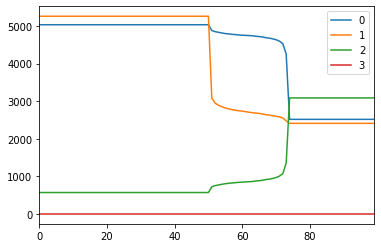

In [340]:
pd.DataFrame(r).plot()

# Pymoo optimisation

In [18]:


class MyRepair(Repair):

    def _do(self, problem, pop, **kwargs):
        for i in range(len(pop)):
            x = pop[i].X
            if len(x) % 2 == 0:
                for j in range(0, len(x), 2):                    
                    if x[j] > x[j + 1]:
                        x[j], x[j + 1] = x[j + 1], x[j]
        return pop
    
    
class FindThresholds(Problem):
    def __init__(self, number_of_thresholds, labels):
        if not len(labels) == number_of_thresholds and not len(labels) * 2 == number_of_thresholds:
            raise ValueError("Number of thresholds must be same size as labels or twice the size")
        
        self.labels = labels    
        self.number_of_thresholds = number_of_thresholds            
        super().__init__(n_var=number_of_thresholds, 
                         n_constr=0, 
                         n_obj=4, 
                         xl=anp.zeros((number_of_thresholds,), dtype=anp.double), 
                         xu=anp.ones((number_of_thresholds,), dtype=anp.double),  
                         type_var=anp.double, 
                         elementwise_evaluation=True)
    
    def _evaluate(self, X, out, *args, **kwargs):
        f0 = []
        f1 = []
        f2 = []
        f3 = []
        
        if self.number_of_thresholds == 1:        
            thresholds = {l: {"lower": X[0], "upper":X[0]} for l in self.labels} 
        elif self.number_of_thresholds == len(self.labels) ** 2:
            thresholds = {}
            for label_index, i in enumerate(range(0, self.number_of_thresholds, 2)):
                thresholds[self.labels[label_index]] = {"lower": X[i], "upper":X[i+1]}
        else:
            thresholds = {}
            for i in range(0, self.number_of_thresholds):
                thresholds[self.labels[i]] = {"lower": X[i], "upper":X[i]} 

        thresholded = calculate_thresholds(self.labels, probabilities, thresholds)
        all_matrices = calculate_all_confusion_matricies(ground_truth, thresholded, self.labels)

        # true matches
        f0.append(all_matrices[:,0][:,0].sum() * -1)   # Maximise the # of true matches

        # false matches
        f1.append(all_matrices[:,1][:,0].sum())

        # missed matches
        f2.append(all_matrices[:,0][:,1].sum())

        # rejects
        f3.append(all_matrices[:,:,2].sum())
            
        out["F"] = anp.column_stack([f0, f1, f2, f3]).astype(anp.double)

In [19]:

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    repair=MyRepair(),
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

ref_points = np.array([[0.5, 0.5, 0.5, 0.5]])
algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=56,
    mu=0.1)


problem = FindThresholds(10, labels)

res = minimize(problem,
               algorithm,
               ("n_gen", 20),
               seed=1,
               save_history=True,
               verbose=True)




Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False



/opt/conda/lib/python3.7/site-packages/pymoo/algorithms/rnsga3.py:142: RuntimeWarning: divide by zero encountered in true_divide
  unit_ref_points = (self.ref_points - self.ideal_point) / (self.nadir_point - self.ideal_point)
/opt/conda/lib/python3.7/site-packages/pymoo/algorithms/rnsga3.py:239: RuntimeWarning: invalid value encountered in multiply
  l = l * d
/opt/conda/lib/python3.7/site-packages/pymoo/algorithms/rnsga3.py:204: RuntimeWarning: invalid value encountered in greater
  if not (ref_dir_for_aspiration_point > 0).min():
/opt/conda/lib/python3.7/site-packages/pymoo/algorithms/rnsga3.py:205: RuntimeWarning: invalid value encountered in less
  ref_dir_for_aspiration_point[ref_dir_for_aspiration_point < 0] = 0


n_gen | n_eval 
1     | 60     
2     | 120    
3     | 180    
4     | 240    
5     | 300    
6     | 360    
7     | 420    
8     | 480    
9     | 540    
10    | 600    
11    | 660    
12    | 720    
13    | 780    
14    | 840    
15    | 900    
16    | 960    
17    | 1020   
18    | 1080   
19    | 1140   
20    | 1200   


In [115]:
F = res.F

weights = np.array([0.7,0.1,0.1,0.1])
I = get_decomposition("weighted-sum").do(F, weights).argmin()
print("Best regarding decomposition: Point %s - %s, %s" % (I, F[I], res.X[I]))

# Best regarding decomposition: Point 0 - [-32.   1.  19.   0.], [0.67100345]

Best regarding decomposition: Point 0 - [-5459. 27106.   143.     0.], [0.00097333 0.84058348 0.68224328 0.28781845 0.00299394 0.6507204
 0.15734461 0.77966049 0.02463698 0.15525791]


In [85]:

X = anp.array(anp.matrix(anp.arange(0,1,0.01)).T)

gd = GradientDescent(anp.array([0.3]), termination=get_termination("n_eval", 200))
gd.evaluator = Evaluator()
gd.problem = FindThresholds(1, labels)

#gd.solve()
res = minimize(FindThresholds(1, labels),
               gd,
               ("n_gen", 300),
               seed=1,
               save_history=True,
               verbose=True)


n_gen | n_eval  | favg         | fopt        
1     | 1       | -35.0000000000 | -35.0000000000
2     | 2       | -35.0000000000 | -35.0000000000
3     | 3       | -35.0000000000 | -35.0000000000
4     | 4       | -35.0000000000 | -35.0000000000
5     | 5       | -35.0000000000 | -35.0000000000
6     | 6       | -35.0000000000 | -35.0000000000
7     | 7       | -35.0000000000 | -35.0000000000
8     | 8       | -35.0000000000 | -35.0000000000
9     | 9       | -35.0000000000 | -35.0000000000
10    | 10      | -35.0000000000 | -35.0000000000
11    | 11      | -35.0000000000 | -35.0000000000
12    | 12      | -35.0000000000 | -35.0000000000
13    | 13      | -35.0000000000 | -35.0000000000
14    | 14      | -35.0000000000 | -35.0000000000
15    | 15      | -35.0000000000 | -35.0000000000
16    | 16      | -35.0000000000 | -35.0000000000
17    | 17      | -35.0000000000 | -35.0000000000
18    | 18      | -35.0000000000 | -35.0000000000
19    | 19      | -35.0000000000 | -35.0000000000
20  

In [26]:
class GradientDescent2(GradientBasedAlgorithm):

    def __init__(self, X, learning_rate=0.005, **kwargs) -> None:
        super().__init__(X, **kwargs)
        self.learning_rate = learning_rate

    def restart(self):
        self.learning_rate /= 2

    def apply(self):
        self.X = self.X - self.learning_rate * self.dX

array([-5602.])